# Example run of some early concept activation vector (CAV) stuff

This file contains some examples of how to run some of the stuff that is made so far. This is still extremely early version, so not that much effort is put into it yet.

In [4]:
# Make notebook update imports automatically if they are changed
%load_ext autoreload  
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from data_loaders import load_concept_data
from cav import CAV

## CAV

We will make a model and rate its concept activation.
To access the dataset, download the MNIST data () and run `data_generator.py`. They are not uploaded because of copyright stuff.

In [6]:
# Load and preprocess data
# NOTE: You will have to download MNIST dataset and run "data_generator.py" to generate these datasets.
# It should only run for a couple second, but the data might be copyrighted.
(x_train_sat, y_train_sat, c_train_sat), (x_val_sat, y_val_sat, c_val_sat), (x_test_sat, y_test_sat, c_test_sat) = \
    load_concept_data("partial95_10.pkl", validation_split=True, normalize=True, reshape=True)

c_train_sat["saturated2"] = c_train_sat["saturated"]  # Add extra concept for testing cav
c_val_sat["saturated2"] = c_val_sat["saturated"]  # This is the exact same concept, but shows that the CAV class can ...
c_test_sat["saturated2"] = c_test_sat["saturated"]  # Have multiple concepts

### Define some models

Lets make two models, and wrap them in a function so that they can be easily reset. The v2 model has a bottleneck layer before the output which makes it more difficult to encode the labels.

In [26]:
def load_model_10_v1():
    """ Load and returns model so that it can be reset easily """
    model_10 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation="relu", input_shape=(28, 28, 1), name="conv1"),
        tf.keras.layers.MaxPooling2D((2, 2), name="max_pool1"),
        tf.keras.layers.Flatten(name="flatten1"),
        tf.keras.layers.Dense(16, activation=None, name="dense1"),
        tf.keras.layers.Activation("relu", name="relu2"),
        tf.keras.layers.Dense(10, activation="softmax", name="dense2")
    ])

    model_10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=["accuracy"])
    return model_10

def load_model_10_v2():
    """ Load and returns model so that it can be reset easily """
    model_10 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation="relu", input_shape=(28, 28, 1), name="conv1"),
        tf.keras.layers.MaxPooling2D((2, 2), name="max_pool1"),
        tf.keras.layers.Flatten(name="flatten1"),
        tf.keras.layers.Dense(16, activation=None, name="dense1"),
        tf.keras.layers.Activation("relu", name="relu2"),
        tf.keras.layers.Dense(6, activation=None, name="dense2"),
        tf.keras.layers.Activation("relu", name="relu3"),
        tf.keras.layers.Dense(10, activation="softmax", name="dense3")
    ])

    model_10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=["accuracy"])
    return model_10

model1 = load_model_10_v1()
model2 = load_model_10_v2()
# model1.summary()
model2.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 26, 26, 16)        160       
                                                                 
 max_pool1 (MaxPooling2D)    (None, 13, 13, 16)        0         
                                                                 
 flatten1 (Flatten)          (None, 2704)              0         
                                                                 
 dense1 (Dense)              (None, 16)                43280     
                                                                 
 relu2 (Activation)          (None, 16)                0         
                                                                 
 dense2 (Dense)              (None, 6)                 102       
                                                                 
 relu3 (Activation)          (None, 6)               

In [27]:
np.random.seed(57)
model1 = load_model_10_v1()
model2 = load_model_10_v2()

n_epochs = 5
cavs1 = np.zeros(n_epochs)
cavs2 = np.zeros(n_epochs)
cavs3 = np.zeros(n_epochs)

for i in range(n_epochs):
    print(f"Epoch number {i}:")
    print("model1:")
    model1.fit(x_train_sat, y_train_sat, epochs=1, batch_size=128)
    cav1 = CAV(model1, ["relu2"])
    acc1 = cav1.train(x_train_sat, c_train_sat)
    cavs1[i] = acc1["relu2"]["saturated"]

    print("model2")
    model2.fit(x_train_sat, y_train_sat, epochs=1, batch_size=128)
    cav2 = CAV(model2, ["relu2", "relu3"])
    acc2 = cav2.train(x_train_sat, c_train_sat, ["saturated"])
    cavs2[i] = acc2["relu2"]["saturated"]
    cavs3[i] = acc2["relu3"]["saturated"]

Epoch number 0:
model1:
375/375 [==============================] - 1s 3ms/step
relu2 saturated
relu2 saturated2
model2
375/375 [==============================] - 1s 3ms/step
relu2 saturated
relu3 saturated
Epoch number 1:
model1:
375/375 [==============================] - 1s 4ms/step
relu2 saturated
relu2 saturated2
model2
375/375 [==============================] - 1s 4ms/step
relu2 saturated
relu3 saturated
Epoch number 2:
model1:
 31/375 [=>............................] - ETA: 3s - loss: 1.6511 - accuracy: 0.4279

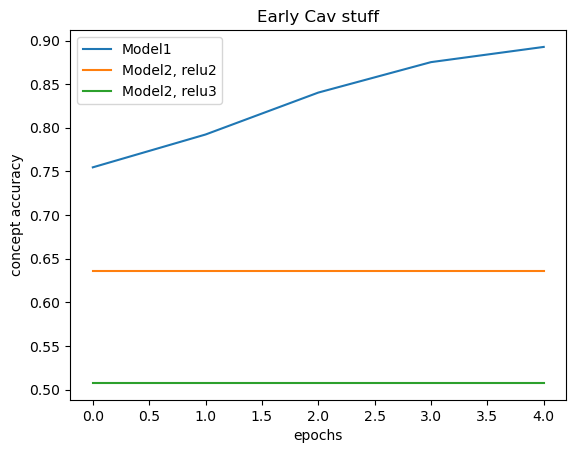

In [25]:
x_values = np.arange(n_epochs)
plt.plot(x_values, cavs1, label="Model1")
plt.plot(x_values, cavs2, label="Model2, relu2")
plt.plot(x_values, cavs3, label="Model2, relu3")
plt.title("Early Cav stuff")
plt.xlabel("epochs")
plt.ylabel("concept accuracy")
plt.legend()
plt.show()